In [1]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

import utils

In [3]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def spatially_averaged_rmse(arr,ref):
    arr = arr[2:-2,2:-2]
    ref = ref[2:-2,2:-2]
    
    arr -= arr.mean()
    ref -= ref.mean()
    
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME', tag='after_full_step'):
#     inner = (slice(2,-2),slice(2,-2))
    inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
#             if N==1:
#                 t_label = '_%.2f_after_full_step' %(time)
#             else:
            t_label = '_ensemble_mem=%i_%.3f_%s' %(n,time, tag)
        elif label_type == 'STEP':
            if N==1:
                t_label = '_%.3d_%s' %(time, tag)
            else:
                t_label = '_ensemble_mem=%i_%.3d_%s' %(n,time, tag)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return np.array(array)

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

def rmse(diff):
    return np.sqrt((diff**2).mean())

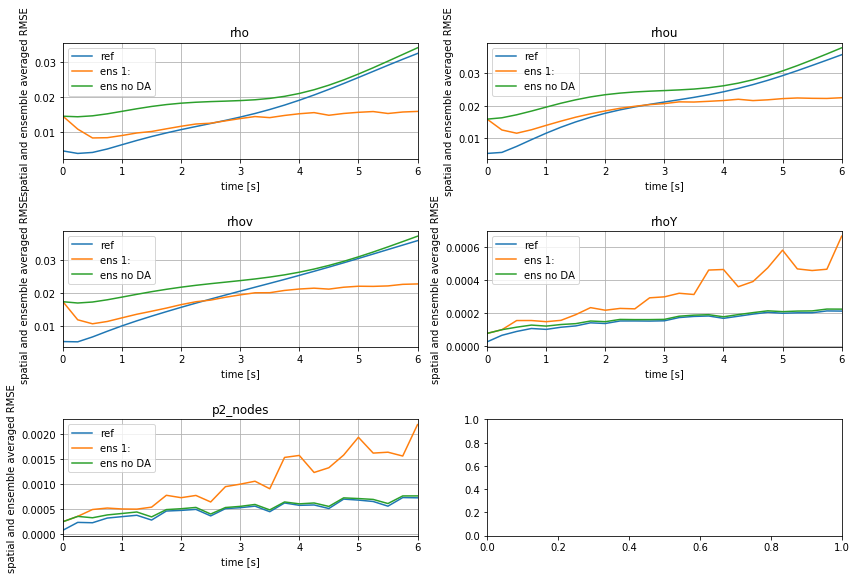

In [11]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

times = np.arange(0.0,6.01,0.25)
base_fn = "output_travelling_vortex"
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
# attributes = ['p2_nodes']

Nx = 32
Ny = 32
et = 6.0
fn = 'batch-obs'

# directory = "%s/write-up/%s" %(base_fn,fn)
directory = "%s" %base_fn
py_directory = "../%s/" %directory

import scipy.ndimage as sciim

tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

plt_lst = []

fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(12,8))

for i,attribute in enumerate(attributes):    
    ref = []
    ref_suffix = 'comp_pp_ref'
    ref.append(tc.get_ensemble(times, 1, attribute, ref_suffix, label_type='TIME'))
    
    ens_noda = []
#     ens_suffix = 'comp_pp_rhos_localised'
    ens_suffix = 'comp_pp_noda'
    ens_noda.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))
    
    ens_1 = []
    ens_suffix = 'comp'
#     ens_suffix = 'comp_rloc'
    ens_1.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))

#     ens_2 = []
#     ens_suffix = 'comp_rloc_localisation'
#     ens_2.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))

    
    truth = []
    truth.append(tc.get_ensemble(times, 1, attribute, 'truthgen', label_type='TIME'))

    diff_ens_1 = tc.spatially_averaged_rmse(ens_1[0],truth[0])
#     diff_ens_2 = tc.spatially_averaged_rmse(ens_2[0],truth[0])
    diff_noda = tc.spatially_averaged_rmse(ens_noda[0],truth[0])
    diff_ref = tc.spatially_averaged_rmse(ref[0],truth[0])
#     diff3 = tc.spatially_averaged_rmse(cb1[0],psinc[0])


    row = int(np.floor(i/2))
    col = int(i%2)
    ax[row,col].plot(times,diff_ref, label='ref')
    ax[row,col].plot(times,diff_ens_1, label='ens 1:')
#     plt.plot(times,diff_ens_2, label='ens 2: r-loc + localisation')
    ax[row,col].plot(times,diff_noda, label='ens no DA')
    ax[row,col].grid()
    ax[row,col].set_title(attribute)
    ax[row,col].legend()
    ax[row,col].set_ylabel("spatial and ensemble averaged RMSE")
    ax[row,col].set_xlabel("time [s]")
    
    ax[row,col].set_xlim([times[0],times[-1]])
    
plt.tight_layout()
plt.savefig('%s/%s.pdf' %(py_directory,fn))
plt.show()

In [ ]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

times = np.arange(0.0,6.01,0.25)
base_fn = "output_travelling_vortex"
py_directory = "../%s/" %base_fn
attributes = ['rho','rhou','rhov','Y']

Nx = 32
Ny = 32
et = 6.0

tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

for attribute in attributes:    
    ens_1 = []
    ens_suffix = 'comp'
    ens_1.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))
    
    ens_noda = []
    ens_suffix = 'comp_pp_noda'
    ens_noda.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))
    
    truth = []
    truth.append(tc.get_ensemble(times, 1, attribute, 'truthgen', label_type='TIME'))

    diff_ens_1 = tc.spatially_averaged_rmse(ens_1[0],truth[0])
    diff_noda = tc.spatially_averaged_rmse(ens_noda[0],truth[0])
    
    
    plt.figure()
    plt.plot(times,diff_ens_1, label='ens 1')
    plt.plot(times,diff_noda, label='ens no DA')
    plt.title("%s" %attribute)
    plt.grid()
    plt.legend()
    plt.show()

# Truth generator
## A travelling vortex translator

In [ ]:
import scipy.ndimage as sciim
import os

attribute = 'rho'
time = 0
# comp_ref_0 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute,label_type='STEP')
# time = 0.25
# comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)

size = 1
grid_x = 64
grid_y = 64
end_time = 6.0
ref_size = size
# suffix = '_truth'
suffix = '_truthgen'

fn = get_filename(grid_x,grid_y,size,end_time,suffix)
print(fn)

path = get_path(fn)
print(path)

fn = get_filename(grid_x,grid_y,size,end_time,'_comp_ref')
py_path_ref_1 = get_path(fn)

fn = get_filename(grid_x,grid_y,size,6.0,'_truthgen')
py_path_ref_2 = get_path(fn)

if os.path.exists(path):
    os.rename(path, path+'_old')
    
file = h5py.File(path, 'a')
attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'Y', 'p2_nodes']
for attr in attributes:
    if not (attr in file):
        file.create_group(attr,track_order=True)
    
file.close()

def roller(arr,n):
    arr = np.roll(arr,n,axis=0)
    arr = np.roll(arr,n,axis=1)
    return arr

# times = np.linspace(0.0,10.0,101*2-1)
# print(times)
# times = [0.0,0.25,0.50,0.75,1.0]
times = np.arange(0.0,6.26,0.005)
steps = range(len(times))
print(steps)
# steps = np.arange(0,321)
# # times = steps / 32
# dt = 1.0 / 32
# times = dt * steps
# print(times)
# print(times)
# print(py_path_ref_1)

# rolled_0 = comp_ref_0.copy()
# rolled_1 = comp_ref_0.copy()

file = h5py.File(path, 'r+')

output_solver = False
print_output = True

# print(py_path_ref_1)
#     print(name)
for attribute in attributes:
    n_step = 0
    comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='TIME')
    rolled_0 = comp_ref_0
    cnt = 0
    
#     name = "ensemble_mem=%i_%.3f_%s" %(0,0,'after_full_step')
#     name = "%.3d_%s" %(0,'after_full_step')
#     file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    for n in steps[:-1]:
        comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='TIME')
        rolled_0 = comp_ref_0
        time = times[cnt]
        name = "ensemble_mem=%i_%.3f_%s" %(0,time,'after_full_step')
#         print(name)
#         name = "%.3d_%s" %(n+1,'after_full_step')
#         print(name)
#         n_step = 65./4 if attribute == 'p2_nodes' else (16.0)
#         n_step = int(n*8.0)
        n_step += (grid_x+1.)/200 if attribute == 'p2_nodes' else (float(grid_x)/200)
        rolled_0 = rolled_0[2:-2,2:-2]
        rolled_0 = np.pad(rolled_0,(1,0),mode='wrap')
        rolled_0 = sciim.shift(rolled_0,n_step, mode='wrap',order=5, prefilter=True)
        rolled_0 = rolled_0[1:,1:]
#         rolled_0 = roller(comp_ref_0[2:-2,2:-2],n_step)
#         rolled_0 = sciim.shift(comp_ref_0[2:-2,2:-2],n_step, mode='wrap')
        rolled_0 = np.pad(rolled_0,2,mode='wrap')
        
        if output_solver == True:
            comp_ref_1 = ensemble_test_case(time, py_path_ref_2,ref_size, attribute, label_type='TIME')
        file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    
# rolled = np.pad(rolled,2,mode='wrap')
        if print_output == True and attribute == 'rho' and n%100==0:
            if output_solver == True:
                fig, ax = plt.subplots(ncols=3, figsize=(9,3))

                ax[0].imshow(comp_ref_1[2:-2,2:-2], origin='lower')
                ax[0].set_title("solver sol.")
                ax[1].imshow(rolled_0[2:-2,2:-2], origin='lower')
                ax[1].set_title("translated sol.")
                im2 = ax[2].imshow(comp_ref_1 - rolled_0, origin='lower')
                ax[2].set_title("difference")
    #             fig.colorbar(im2,ax=ax[2],shrink=0.4)
                fig.colorbar(im2, ax=ax, shrink=.75)
                fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
                plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
                plt.show()
            else:
                fig = plt.figure(figsize=(3,3))
                plt.imshow(rolled_0[2:-2,2:-2], origin="lower")
                plt.title("time=%.2f, measurement=%s" %(time,attribute))
                plt.colorbar(shrink=.8)
                plt.show()
                
        cnt += 1
    
file.close()
print("Completed")